In [2]:
import numpy as np
from qiskit_aer import Aer
from qiskit import QuantumCircuit
import sympy as sp
import matplotlib.pyplot as plt

from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms import VQE
from qiskit.primitives import Estimator

from qiskit_algorithms.optimizers import SPSA
from scipy.optimize import minimize

from tqdm import tqdm


plt.rcParams['text.usetex'] = True


%matplotlib widget

## Part A

We consider a one-qubit system and we define its basis states and we apply the various Pauli matrices $(X,Y,Z)$, Hadamard gate ($H$), and Phase gate ($S$). 
The result of these actions on each of the basis states can be observed in the otput cells below.
It is important to notice that the one-qubit basis vectors $\ket{0},$ and $\ket{1}$  also eigenvectors of the Pauli matrix $Z$ with eigenvalues $1$ and $-1$.

In [3]:
def numpy_to_sympy(arr, constants=[sp.sqrt(2)]):
    """
    Convert a NumPy array to a Sympy Matrix with each element simplified.
    
    Parameters:
      arr (np.array): The NumPy array to convert.
      constants (list): Constants to use for nsimplify (default includes sqrt(2)).
    
    Returns:
      sp.Matrix: A symbolic matrix with simplified elements.
    """

    arr = np.array(arr)  # Ensure it's a NumPy array
    if arr.ndim == 1:
        return sp.Matrix([sp.nsimplify(x, constants) for x in arr])
    elif arr.ndim >1:
        return sp.Matrix([[sp.nsimplify(x, constants) for x in row] for row in arr])
    else:
        # For higher dimensions, you might want to extend this approach.
        raise ValueError("Array with ndim > 2 is not supported.")
    
# Define Pauli Matrices (X, Y, Z), Hadamard gate (H), Phase gate (S)
state0 = np.array([1, 0])
state1 = np.array([0, 1])
state00 = np.kron(state0, state0)
state01 = np.kron(state0, state1)
state10 = np.kron(state1, state0)
state11 = np.kron(state1, state1)

X = np.array([[0, 1],
                [1, 0]])
Y = np.array([[0, -1j],
                [1j, 0]])
Z = np.array([[1, 0],
                [0, -1]])
H = (1/np.sqrt(2)) * np.array([[1,  1],
                                [1, -1]])
S = np.array([[1, 0],
                [0, 1j]])
I = np.array([[1,0],
              [0,1]])
# One qubit
basis_states = {'|0>': state0, '|1>': state1, '|00>':state00, '|01>':state01, '|10>':state10, '|11>':state11}
gates = {'X': X, 'Y': Y, 'Z': Z, 'H': H, 'S': S}


Here we apply gates to basis state $\ket{0}$

In [4]:
state_label = list(basis_states.keys())[0]
state_value = list(basis_states.values())[0]

print(f"State {state_label}: {state_value}")
for gate_name, gate in gates.items():
    result = np.dot(gate, state_value)
    # Convert the result to a symbolic matrix.
    sym_result = numpy_to_sympy(result)
    print(f"  Applying {gate_name} gate to {state_label}")
    sp.pprint(sym_result)
print("\n")


State |0>: [1 0]
  Applying X gate to |0>
⎡0⎤
⎢ ⎥
⎣1⎦
  Applying Y gate to |0>
⎡0⎤
⎢ ⎥
⎣ⅈ⎦
  Applying Z gate to |0>
⎡1⎤
⎢ ⎥
⎣0⎦
  Applying H gate to |0>
⎡√2⎤
⎢──⎥
⎢2 ⎥
⎢  ⎥
⎢√2⎥
⎢──⎥
⎣2 ⎦
  Applying S gate to |0>
⎡1⎤
⎢ ⎥
⎣0⎦




Here we apply gates to basis state $\ket{1}$

In [5]:
state_label = list(basis_states.keys())[1]
state_value = list(basis_states.values())[1]

print(f"State {state_label}: {state_value}")
for gate_name, gate in gates.items():
    result = np.dot(gate, state_value)
    # Convert the result to a symbolic matrix.
    sym_result = numpy_to_sympy(result)
    print(f"  Applying {gate_name} gate to {state_label}")
    sp.pprint(sym_result)
print("\n")

State |1>: [0 1]
  Applying X gate to |1>
⎡1⎤
⎢ ⎥
⎣0⎦
  Applying Y gate to |1>
⎡-ⅈ⎤
⎢  ⎥
⎣0 ⎦
  Applying Z gate to |1>
⎡0 ⎤
⎢  ⎥
⎣-1⎦
  Applying H gate to |1>
⎡ √2 ⎤
⎢ ── ⎥
⎢ 2  ⎥
⎢    ⎥
⎢-√2 ⎥
⎢────⎥
⎣ 2  ⎦
  Applying S gate to |1>
⎡0⎤
⎢ ⎥
⎣ⅈ⎦




Bell states are a set of four specific, maximally entangled two-qubit states. 
The $\ket{\Phi^+}$ Bell state can  be practically created with a quantum circuit. In particular, starting from the two qubit input $\ket{00}$ we can apply a Hadamard gate on the first qubit and then a CNOT gate.
The 4 Bell states are calculated in the following cell.
In addition, we apply a Hadamard gate and a CNOT gate on the Bell state $\ket{\Phi^+}$ and we obtain a new state $\psi$
$$
\psi = 
\begin{bmatrix}
1/2 \\
1/2 \\
1/2 \\
-1/2\end{bmatrix}
$$

In [6]:
# 2 qubits system
# Define Bell States
phi_plus = 1/np.sqrt(2) * (state00 + state11)
phi_minus = 1/np.sqrt(2) * (state00 - state11)

psi_plus = 1/np.sqrt(2) * (state01 + state10)
psi_minus = 1/np.sqrt(2) * (state01 - state10)

# Apply Hadamard gate only to first bit qubit of phi_plus and then CNOT gate
CNOT = np.zeros((4,4))
CNOT[0,0] = 1; CNOT[1,1] = 1; CNOT[2,3] = 1; CNOT[3,2] = 1
new_state = CNOT @ np.kron(H, I) @ psi_plus
new_state_sp = numpy_to_sympy(new_state)
print("Final state: ")
sp.pretty_print(new_state_sp)

Final state: 
⎡1/2 ⎤
⎢    ⎥
⎢1/2 ⎥
⎢    ⎥
⎢1/2 ⎥
⎢    ⎥
⎣-1/2⎦


In this cell, we simulate sequential measurements in a two-qubit system (inspired by R. Hundt's *Quantum Computing for Programmers*, 2002, Sec. 2.15).

First, we measure the first qubit, collapsing it to either \(|0\rangle\) or \(|1\rangle\). After renormalizing the state, we measure the second qubit. Repeating this process over many shots provides the probability distribution for the four outcomes:
$$
|00\rangle,\quad |01\rangle,\quad |10\rangle,\quad |11\rangle.
$$

After 10,000 measurements, each outcome is observed with an approximate probability of 25%. This result is consistent with the state
$$
|\psi\rangle = \frac{1}{2}|00\rangle + \frac{1}{2}|01\rangle + \frac{1}{2}|10\rangle - \frac{1}{2}|11\rangle,
$$
since the magnitude squared of each coefficient is

$$
\left|\frac{1}{2}\right|^2 = \frac{1}{4}.
$$


In [7]:
# Measurement
# Define helper function for the Kronecker power.
def matrix_kron_power(A, n):
    """Return the n–fold Kronecker product of matrix A with itself."""
    if n < 1:
        return np.array([1])
    result = A
    for i in range(1, n):
        result = np.kron(result, A)
    return result

def measure(psi, idx=0, tostate=0, collapse=True):
    
    # Determine the number of qubits.
    n = int(np.log2(len(psi)))

    # Density matrix
    rho = np.outer(psi, psi.conj())

    # Define projectors
    if tostate == 0:
        op = np.outer(state0,state0)
    else:
        op = np.outer(state1, state1)

    # Augment the projector
    if idx > 0:
        op = np.kron(matrix_kron_power(np.eye(2), idx), op)
    if idx < n - 1:
        op = np.kron(op, matrix_kron_power(np.eye(2), n - idx - 1))

    prob0 = np.trace(np.matmul(op, rho))
    if collapse:
        mvul = np.dot(op, psi)
        divisor = np.real(np.linalg.norm(mvul))
        if divisor > 1e-10:
            normed = mvul/divisor
        else:
            raise AssertionError(
                "Measure collapsed to 0.0 probability state"
            )
        return np.real(prob0), normed

    return np.real(prob0), psi

states = {"00":0, "01":0, "10":0, "11":0}

nshots = 10000
for shot in range(nshots):
    # First we measure the first qubit and we get the probability that the first qubit is |0>
    probability_qubit1_0, _ = measure(new_state, idx=0, tostate=0, collapse=True)
    # Measure the first quibit and we get the probability that the first qubit is |1>
    probability_qubit1_1, _ = measure(new_state, idx=0, tostate=1, collapse=True)

    state_qubit1 = np.random.binomial( 1, probability_qubit1_0)

    # We measure qubit 1 and the new state is
    _, state_after_measuring_q1 = measure(new_state, idx=0, tostate=state_qubit1, collapse=True)

    # Now we measure qubit 2
    probability_qubit2_0, _ = measure(state_after_measuring_q1, idx=1, tostate=0, collapse=True)
    # Measure the first quibit and we get the probability that the first qubit is |1>
    probability_qubit2_1, _ = measure(state_after_measuring_q1, idx=1, tostate=1, collapse=True)

    state_qubit2 = np.random.binomial(1, probability_qubit2_0)

    final_state = measure(state_after_measuring_q1, idx=1, tostate=state_qubit2, collapse=True)

    states[str(state_qubit1)+str(state_qubit2)] +=1

print(states)
for key, value in states.items():
    print(key, round(value/nshots*100))


{'00': 2534, '01': 2457, '10': 2520, '11': 2489}
00 25
01 25
10 25
11 25


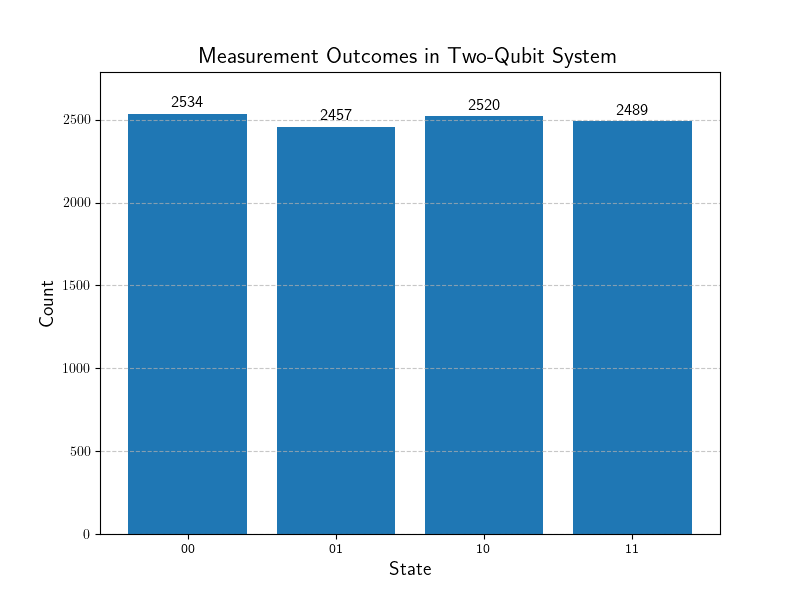

In [8]:
import matplotlib.pyplot as plt

# Data from the measurement outcomes
labels = list(states.keys())
values = list(states.values())

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values)

# Annotate bars with the count values
for bar, count in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, f'{count}', 
             ha='center', va='bottom', fontsize=12)

plt.title('Measurement Outcomes in Two-Qubit System', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.ylim(0, max(values) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


We can compare our algorithm results with the results obtained from Qiskit.


=== Measurement result ===

{'01': 2489, '10': 2523, '00': 2445, '11': 2543}


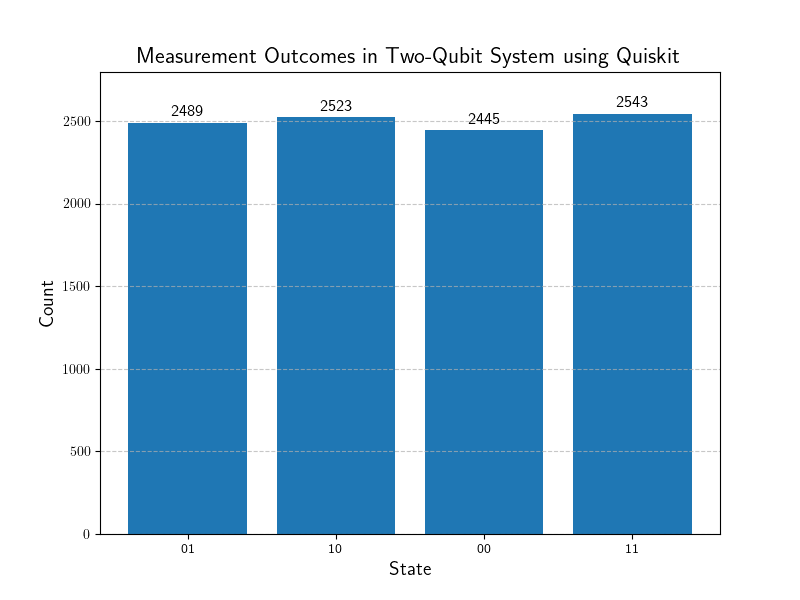

In [9]:
def simulate_bell_state(shots=1024):
    # Create a quantum circuit with 2 qubits and 2 classical bits
    qc = QuantumCircuit(2, 2)
    
    # Prepare Bell state |Φ+> = (|00> + |11>)/sqrt(2)
    qc.h(0)     # Apply Hadamard on qubit 0
    qc.cx(0, 1) # Apply CNOT with qubit 0 as control and qubit 1 as target
    
    # Apply Hadamard and 
    qc.h(0)
    qc.cx(0,1)
    # Measure both qubits
    qc.measure(0, 0)  # Measure qubit 0 into classical bit 0
    qc.measure(1, 1)  # Measure qubit 1 into classical bit 1
    
    # Execute the circuit on the qasm simulator
    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(qc, backend=simulator, shots=shots).result()
    counts = result.get_counts(qc)
    
    print(counts)
    labels = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values)

    # Annotate bars with the count values
    for bar, count in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 20, f'{count}', 
                ha='center', va='bottom', fontsize=12)

    plt.title('Measurement Outcomes in Two-Qubit System using Quiskit', fontsize=16)
    plt.xlabel('State', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.ylim(0, max(values) * 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


print("=== Measurement result ===\n")
simulate_bell_state(shots=10000)


## Part B

We consider a symmetric matrix $H = H_0 + \lambda H_I,$ where $H_0$ represent the non interactive part, $H_I$ the interactive part, and $\lambda \in [0,1]$ is a strength parameter.
For $\lambda = 0,$ we obtain the non-interacting system and for $\lambda = 1, $ we have fully interacting system.
Therefore we write $H$ as 

$$
H = H_0 + \lambda H_I = \begin{bmatrix}
E_1 & 0 \\
0 & E_2 \\
\end{bmatrix} + \lambda \begin{bmatrix}
V_{11} & V_{12} \\
V_{21} & V_{22} \\
\end{bmatrix},
$$
with $E_1 = 0, E_2 = 4 V_{11} = 3, V_{22} = -3, V_{12} = V_{21} = 0.2.$


We rewrite \(H\) (as well as \(H_0\) and \(H_I\)) in terms of the Pauli matrices.

The unperturbed Hamiltonian is given by
$$
H_0 = E\,I + \Omega\,\sigma_z,
$$
where
$$
E = \frac{E_1 + E_2}{2}, \quad \Omega = \frac{E_1 - E_2}{2}.
$$

The interaction Hamiltonian is expressed as
$$
H_I = c\,I + \omega_z\,Z + \omega_x\,X,
$$
with $c = (V_{11} + V_{22} )/2$, $\omega_z = (V_{11} − V_{22})/2$ and $\omega_x = V_{12} = V_{21}$.

First, we can compute the eigenvalues of the system as a function of the strength parameter $\lambda$ using the Numpy library LinAlg.
In the cells below the eigenvalues as a function of $\lambda$ are computed and plotted in a graph.

In [10]:
E1 = 0
E2 = 4
V11 = 3
V22 = -3
V12 = 0.2
V21 = 0.2
H_0 = np.array([[E1, 0],[0,E2]])
H_I = np.array(([[V11, V12],[V21, V22]]))

H = H_0 + H_I
H_0_sp = numpy_to_sympy(H_0)
H_I_sp = numpy_to_sympy(H_I)
H_sp = numpy_to_sympy(H)

sp.pretty_print(H_0_sp)
sp.pretty_print(H_I_sp)
sp.pretty_print(H_sp)

⎡0  0⎤
⎢    ⎥
⎣0  4⎦
⎡ 3   1/5⎤
⎢        ⎥
⎣1/5  -3 ⎦
⎡ 3   1/5⎤
⎢        ⎥
⎣1/5   1 ⎦


We can observe that at $\lambda = 2/3$ the character of the eigenvectors has therefore been interchanged.

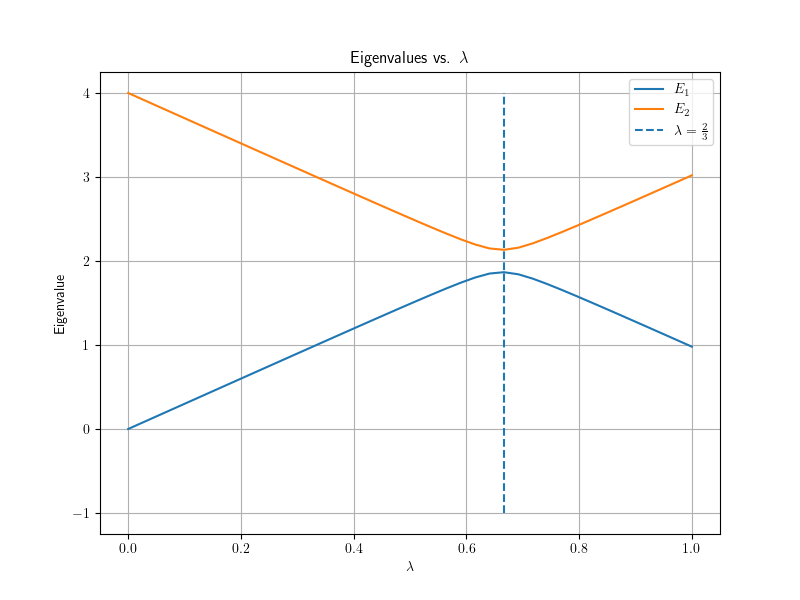

In [11]:
import matplotlib.pyplot as plt
# We can weight the interaction matrix with a parameter \lambda
#number of lambda values
n = 40
lmbdas = np.linspace(0.0,1.0,n)
Eigenvalue = np.zeros((2,n))
Eigvector = [np.zeros((2,2)).copy() for _ in range(n)]

for i in range(n):
    lmbda = lmbdas[i]
    H = H_0 + lmbda * H_I
    eigenvalues, eigenvectors = np.linalg.eig(H)
    permute = eigenvalues.argsort()
    eigenvalues = eigenvalues[permute]
    eigenvectors = eigenvectors[:,permute]
    Eigenvalue[0,i] = eigenvalues[0]
    Eigenvalue[1,i] = eigenvalues[1]
    Eigvector[i][:,0] = eigenvectors[0]
    Eigvector[i][:,1] = eigenvectors[1]
    
plt.figure(figsize=(8, 6))
plt.plot(lmbdas, Eigenvalue[0, :], label=r"$E_1$")
plt.plot(lmbdas, Eigenvalue[1, :], label=r"$E_2$")
plt.vlines(x=2/3, ymin=-1, ymax=4, linestyles="--", label=r"$\lambda=\frac{2}{3}$")
plt.xlabel(r"$\lambda$")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues vs. $\lambda$")
plt.legend()
plt.grid(True)
plt.show()

## Part C

In the following cells, we determine the system's ground state energy using the Variational Quantum Eigensolver (VQE). 

The procedure starts by initializing the system in the $\ket{0}$ state and constructing an ansatz via sequential $R_x$ and $R_y$ rotations parameterized by two angles. 
Energy is then evaluated by performing measurements in the appropriate Pauli bases—applying necessary unitary transformations—and estimating the expected value from repeated Z-basis measurements. 

Finally, a classical optimizer (using SciPy) minimizes the energy function to yield the optimal parameters and corresponding eigenstate. 
In summary, energy evaluation is performed through quantum measurements (potentially on a quantum computer), while minimization is carried out on a classical computer.


In [12]:
# Code from FYS-5419 course. Author: Morten Hjorth-Jensen

from qc import *

def prepare_state(theta, phi, target = None):
    I = np.eye(2)
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    state = np.array([1, 0])
    Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * sigma_x
    Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * sigma_y
    state = Ry @ Rx @ state
    if target is not None:
        state = target
    return state

def get_energy(angles, lmb, number_shots, target = None):
    theta, phi = angles[0], angles[1]
    # print(f'Theta = {theta}, Phi = {phi}')
    E1 = 0; E2 = 4; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2

    eps = (E1 + E2) / 2; omega = (E1 - E2) / 2; c = (V11 + V22) / 2; omega_z = (V11 - V22) / 2; omega_x = V12

    init_state = prepare_state(theta, phi, target)
    qubit = One_qubit()
    qubit.set_state(init_state)
    measure_z = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_hadamard()
    measure_x = qubit.measure(number_shots)
    
    # expected value of Z = (number of 0 measurements - number of 1 measurements)/ number of shots
    # number of 1 measurements = sum(measure_z)
    exp_val_z = (omega + lmb*omega_z)*(number_shots - 2*np.sum(measure_z)) / number_shots
    exp_val_x = lmb*omega_x*(number_shots - 2*np.sum(measure_x)) / number_shots
    exp_val_i = (eps + c*lmb) 
    exp_val = (exp_val_z + exp_val_x + exp_val_i)
    return exp_val 

In [13]:
number_shots = 10_000
lmbvalues_scipy = np.linspace(0.0, 1.0, 50)
min_energy_scipy = np.zeros(len(lmbvalues_scipy))
for index, lmb in enumerate(tqdm(lmbvalues_scipy)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 2)
    res = minimize(get_energy, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun

100%|██████████| 50/50 [00:03<00:00, 13.91it/s]


In [14]:
# Express Hamiltonian as function of Pauli matrix and compute VQE
# Code taken from IBM Variational quantum eigensolver
epsilon = (E1 + E2)/2
omega = (E1 - E2)/2
c = (V11 + V22)/2
omegaz = (V11 - V22)/2
omegax = V12

In addition, we can utilize the software Qiskit 

In [15]:
# Inspired by this: https://github.com/qiskit-community/qiskit-algorithms/blob/stable/0.3/docs/tutorials/01_algorithms_introduction.ipynb
num_qubits = 1
ansatz = TwoLocal(num_qubits, rotation_blocks=["rx", "ry"], reps=0)
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
minimum_eigenvalues = []
for lmbda in np.linspace(0,1,10):

    hamiltonian = SparsePauliOp.from_list(
        [("I", epsilon + lmbda*c), ("Z", omega + lmbda*omegaz), ("X", lmbda*omegax)]
    )

    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    minimum_eigenvalues += [result.eigenvalue]
    



/tmp/ipykernel_47157/576641091.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})


In [16]:
print(ansatz.draw(output='text'))

   ┌─────────────────────┐
q: ┤ TwoLocal(θ[0],θ[1]) ├
   └─────────────────────┘


The results from the three approaches—direct linear algebra using NumPy, VQE with a SciPy optimizer, and VQE via Qiskit—are in excellent agreement.

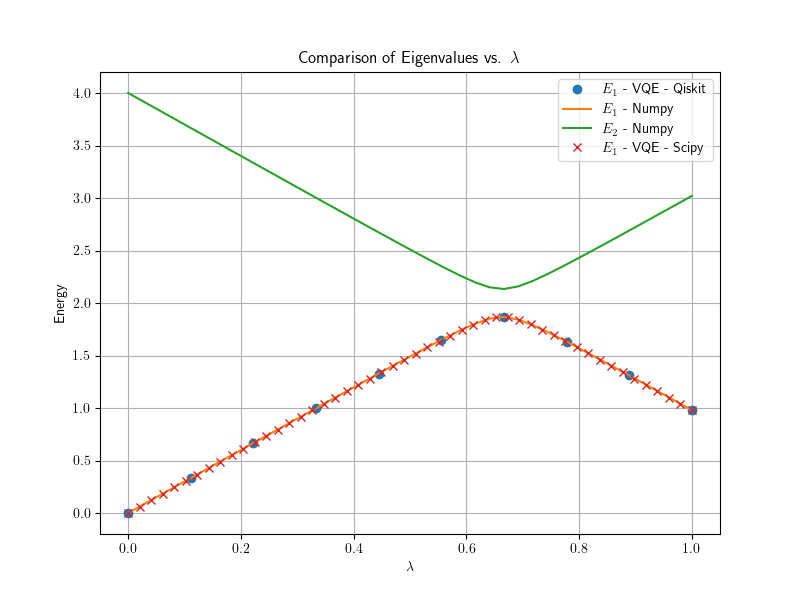

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 1, 10), minimum_eigenvalues, linestyle="", marker="o", label=r"$E_1$ - VQE - Qiskit")
plt.plot(lmbdas, Eigenvalue[0, :], label=r"$E_1$ - Numpy")
plt.plot(lmbdas, Eigenvalue[1, :], label=r"$E_2$ - Numpy")
plt.plot(lmbvalues_scipy, min_energy_scipy, marker="x", linestyle="", label=r"$E_1$ - VQE - Scipy")

plt.xlabel(r"$\lambda$")
plt.ylabel("Energy")
plt.title("Comparison of Eigenvalues vs. $\lambda$")
plt.legend()
plt.grid(True)
plt.show()

## Part D and E

In this part we will consider a 2 qubits system.
The Hamiltonian reads as follow
$$
H = \begin{pmatrix}
\epsilon_{00} + H_z & 0                  & 0                  & H_x \\
0                  & \epsilon_{01} - H_z & H_x                & 0 \\
0                  & H_x                & \epsilon_{10} - H_z & 0 \\
H_x                & 0                  & 0                  & \epsilon_{11} + H_z
\end{pmatrix},
$$
with $H_x=2.0,$ $H_z=3.0,$ $\epsilon_{00}=0,\epsilon_{01}=2.5, \epsilon_{10}=6.5, \epsilon_{11}=7.0.$

As done previously, we can decompose the Hamiltonian in a non-interacting part $H_0$ and an interacting part $H_I.$ weighted by a strenght parameter $\lambda.$

The Hamiltonian can be written as function of Pauli matrices:

$$
\begin{aligned}
A &= \frac{\epsilon_{00} + \epsilon_{01} + \epsilon_{10} + \epsilon_{11}}{4}, \\
B &= \frac{\epsilon_{00} - \epsilon_{01} + \epsilon_{10} - \epsilon_{11}}{4}, \\
C &= \frac{\epsilon_{00} + \epsilon_{01} - \epsilon_{10} - \epsilon_{11}}{4}, \\
D &= \frac{\epsilon_{00} - \epsilon_{01} - \epsilon_{10} + \epsilon_{11}}{4}, \\
H &= A\,(I \otimes I) + B\,(I \otimes \sigma_z) + C\,(\sigma_z \otimes I) + (D + H_z)\,(\sigma_z \otimes \sigma_z) + H_x\,(\sigma_x \otimes \sigma_x).
\end{aligned}
$$


In [18]:
# We extend the Hamiltonian to a 2 qubits system

eps00 = 0.0
eps10 = 2.5
eps01 = 6.5
eps11 = 7.0
Hx = 2.0 
Hz = 3.0

lmbda = 1
H_0 = np.array([[eps00, 0, 0,0],[0, eps01, 0, 0],[0, 0, eps10, 0],[0, 0, 0, eps11]])
H_I = Hz*np.kron(Z, Z) + Hx*np.kron(X, X)

H = H_0 + lmbda*H_I
H_sp = numpy_to_sympy(H)
sp.pretty_print(H_sp)


⎡3   0    0    2 ⎤
⎢                ⎥
⎢0  7/2   2    0 ⎥
⎢                ⎥
⎢0   2   -1/2  0 ⎥
⎢                ⎥
⎣2   0    0    10⎦


In [19]:
ket0 = np.array([1, 0])
ket1 = np.array([0, 1])

sigma_x = np.array([[0, 1], [1, 0]])
sigma_z = np.array([[1, 0], [0, -1]])
ket0 = np.array([1, 0])
ket1 = np.array([0, 1])
I = np.eye(2)

def Hamiltonian(lmb):    
    Hx = 2.0 
    Hz = 3.0
    H0Energiesnoninteracting = [0.0, 2.5, 6.5, 7.0]
    
    HI = Hz*np.kron(sigma_z, sigma_z) + Hx*np.kron(sigma_x, sigma_x)
    H0 = np.diag(H0Energiesnoninteracting)
    H = H0 + lmb*HI
    return H

def trace_out(state, index):
    density = np.outer(state, np.conj(state))
    if index == 0:
        op0 = np.kron(ket0, I)
        op1 = np.kron(ket1, I)
    elif index == 1:
        op0 = np.kron(I, ket0)
        op1 = np.kron(I, ket1)
    return op0.conj() @ density @ op0.T + op1.conj() @ density @ op1.T # need to take conj() on first and .T on second since np.arrays are 


We can compute the system's ground state energy as a function of the strength parameter $\lambda$ using the Variational Quantum Eigensolver (VQE) for a two-qubit system. 
In this approach, our ansatz is constructed by applying two consecutive rotations ($R_x$​ and $R_y​$) on the first qubit and two on the second qubit, followed by a CNOT gate to entangle the qubits. As a result, the energy becomes a function of four angles. We then evaluate the energy via quantum measurements and use classical optimization to minimize this function, thereby obtaining the lowest eigenvalue of the system.

In [20]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, lmb, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    Hx = 2.0 
    Hz = 3.0
    eps00, eps01, eps10, eps11 = np.array([0.0, 2.5, 6.5, 7.0])
    A = (eps00 + eps01 + eps10 + eps11) / 4.0
    B = (eps00 - eps01 + eps10 - eps11) / 4.0
    C = (eps00 + eps01 - eps10 - eps11) / 4.0
    D = (eps00 - eps01 - eps10 + eps11) / 4.0
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_cnot10() # rotate measurement basis
    measure_zz = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_zz, measure_xx])
    constants = np.array([B, C, D + lmb*Hz, lmb*Hx])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = A + np.sum(constants * exp_vals) / number_shots
    return exp_val


In [21]:
number_shots = 10_000
lmbvalues = np.linspace(0.0, 1.0, 50)
min_energy_scipy = np.zeros(len(lmbvalues))
for index, lmb in enumerate(tqdm(lmbvalues)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun

100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


We can 

In [22]:
n = 100
lmbdas = np.linspace(0.0,1.0,n)
Eigenvalue = np.zeros((4,n))
Eigvector = [np.zeros((4,4)).copy() for _ in range(n)]
entropy = np.zeros((n, 4))

for i in range(n):
    lmbda = lmbdas[i]
    H = H_0 + lmbda*H_I
    eigenvalues, eigenvectors = np.linalg.eig(H)
    permute = eigenvalues.argsort()
    eigenvalues = eigenvalues[permute]
    eigenvectors = eigenvectors[:,permute]
    Eigenvalue[0,i] = eigenvalues[0]
    Eigenvalue[1,i] = eigenvalues[1]
    Eigenvalue[2,i] = eigenvalues[2]
    Eigenvalue[3,i] = eigenvalues[3]
    Eigvector[i][:,0] = eigenvectors[0]
    Eigvector[i][:,1] = eigenvectors[1]
    Eigvector[i][:,2] = eigenvectors[2]
    Eigvector[i][:,3] = eigenvectors[3]
    for j in range(4):
        sub_density = trace_out(eigenvectors[:, j], 0) # trace out qubit 0 from the ground state
        lmb_density = np.linalg.eigvalsh(sub_density)
        lmb_density = np.ma.masked_equal(lmb_density, 0).compressed() # remove zeros to avoid log(0)
        entropy[i, j] = -np.sum(lmb_density*np.log2(lmb_density))




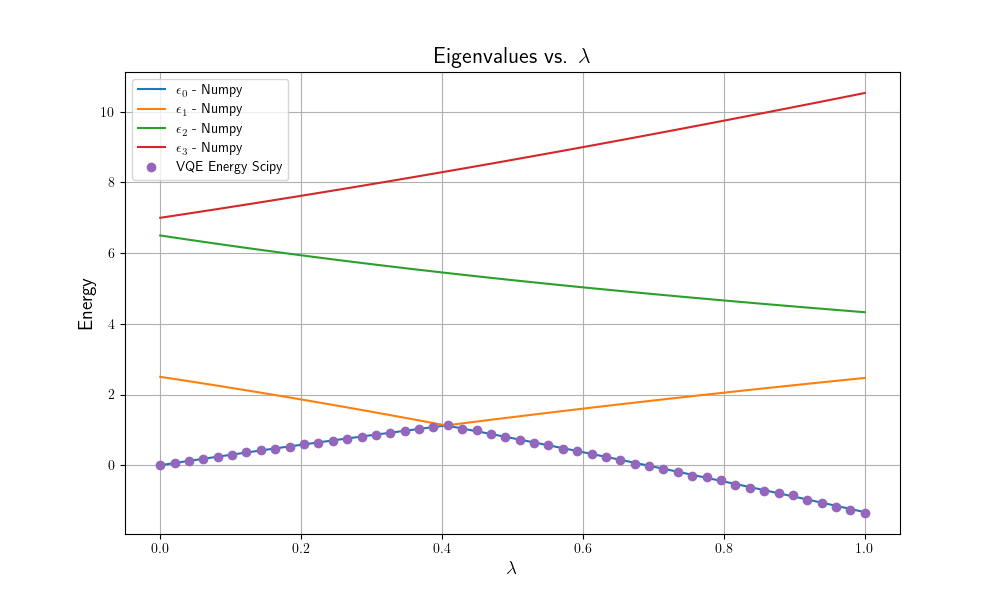

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(lmbdas, Eigenvalue[0, :], label=r'$\epsilon_{0}$ - Numpy')
plt.plot(lmbdas, Eigenvalue[1, :], label=r'$\epsilon_{1}$ - Numpy')
plt.plot(lmbdas, Eigenvalue[2, :], label=r'$\epsilon_{2}$ - Numpy')
plt.plot(lmbdas, Eigenvalue[3, :], label=r'$\epsilon_{3}$ - Numpy')
plt.plot(lmbvalues, min_energy_scipy, label='VQE Energy Scipy', marker='o', linestyle="")

plt.xlabel(r'$\lambda$', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Eigenvalues vs. $\lambda$', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


We observe a pronounced increase in entropy near the level crossing ($\lambda=0.4$). At zero interaction ($λ=0$), the many-body states are purely given by their computational basis configurations. As the interaction is gradually introduced, the states become increasingly mixed, leading to higher entropy, until the level crossing triggers a sudden further rise. This pattern is also evident in the other states. The key takeaway is that the Hamiltonian through the interplay of its non-interacting energy levels and the strength of its interaction matrix elements—directly governs the emergence of entanglement.

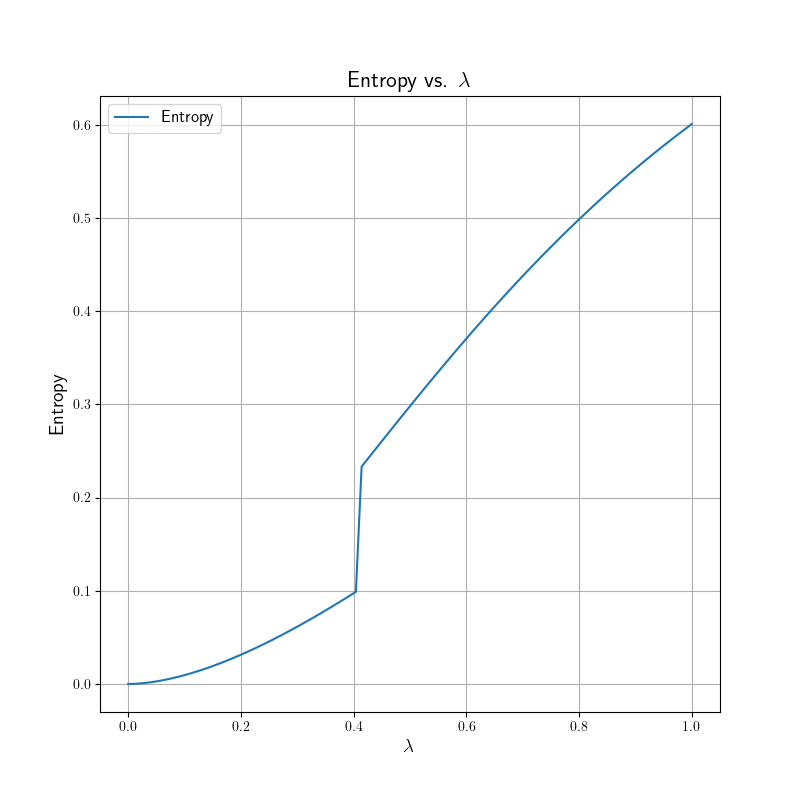

In [24]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(lmbdas, entropy[:, 0], label='Entropy')
ax.set_xlabel(r'$\lambda$', fontsize=14)
ax.set_ylabel('Entropy', fontsize=14)
ax.set_title('Entropy vs. $\lambda$', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True)
plt.show()

We can also utilize Qiskit to compute the lowest eigenvalue of the system.

In [25]:
# We can compute min eigenvalue using quiskit

# Rewrite Hamiltonian as function of Pauli Matrices

A = (eps00 + eps01 + eps10 + eps11) / 4.0 # IxI
B = (eps00 - eps01 + eps10 - eps11) / 4.0 # IxZ
C = (eps00 + eps01 - eps10 - eps11) / 4.0 # ZxI
D = (eps00 - eps01 - eps10 + eps11) / 4.0 # ZxZ

# Generate ansatz for 2 qubit system


In [26]:
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
from qiskit_algorithms.utils import algorithm_globals

minimum_eigenvalues_2q = []
for i, lmbda in enumerate(tqdm(np.linspace(0,1,20))):
    hamiltonian_2qb= SparsePauliOp.from_list(
        [("II", A), ("IZ", B), ("ZI", C), ("ZZ", lmbda*Hz+D), ("XX", lmbda*Hx)]
    )
    ansatz = TwoLocal(num_qubits=2, rotation_blocks=["rx","ry"], entanglement_blocks="cx")
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_2qb)
    minimum_eigenvalues_2q +=[result.eigenvalue.real]


/tmp/ipykernel_47157/1970686408.py:1: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
100%|██████████| 20/20 [00:52<00:00,  2.61s/it]


Here we can print the ansatz generated with Qiskit

In [27]:
ansatz = TwoLocal(num_qubits=2, rotation_blocks=["rx","ry"], entanglement_blocks="cx", reps=0)
print(ansatz.draw(output='text'))

     ┌────────────────────────────────┐
q_0: ┤0                               ├
     │  TwoLocal(θ[0],θ[1],θ[2],θ[3]) │
q_1: ┤1                               ├
     └────────────────────────────────┘


In the figure below, we can observe how the 3 approaches: classical numpy solver, VQE approach using Scipy optimizer and VQE with Qiskit converge to the same values of the smalleste eigenvalue.

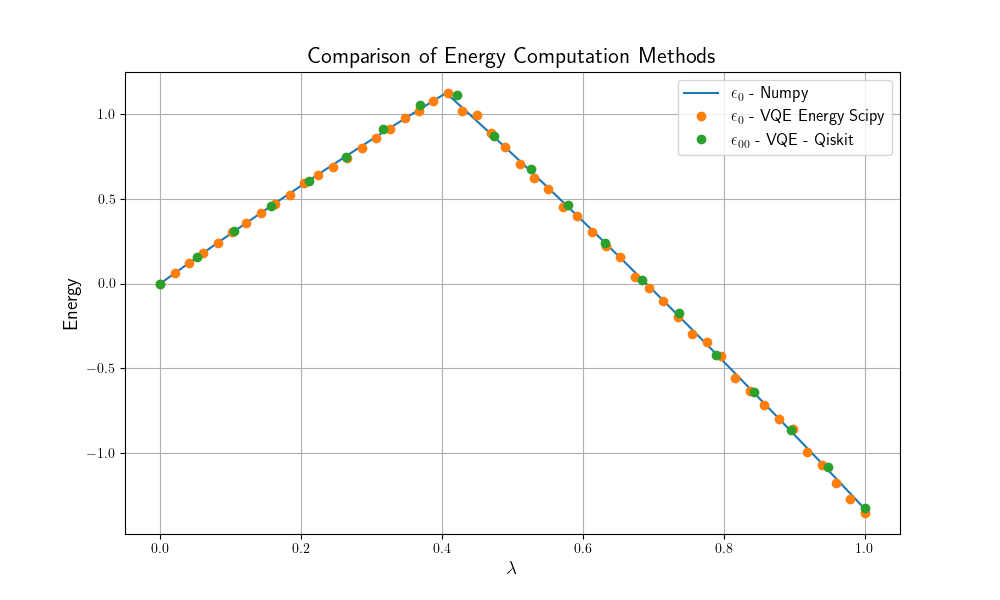

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(lmbdas, Eigenvalue[0, :], label=r'$\epsilon_{00}$ - Numpy')
plt.plot(lmbvalues, min_energy_scipy, label=r'$\epsilon_{00}$ - VQE Energy Scipy', marker='o', linestyle="")
plt.plot(np.linspace(0,1,20), minimum_eigenvalues_2q, linestyle="", marker="o", label=r'$\epsilon_{00}$ - VQE - Qiskit')

plt.xlabel(r'$\lambda$', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.title('Comparison of Energy Computation Methods', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## Part F

In the following sections, we will introduce the Lipkin Hamiltonian and study it for the cases J = 1 (3x3 matrix), and for the the J = 2 (5 × 5 matrix).
More details can be found in the Physical Review C, volume 106, see https://journals.aps.org/prc/pdf/10.1103/PhysRevC.106.024319.

In [29]:
# Hamiltonian for 2 particles J = 1, Jz = {-1, 0, 1}
# Hamiltonian for 4 particles J = 2, Jz = {-2, -1, 0, 1, 2}
#function that sorts eigenvalues with its eigenvectors in accending order
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

def Hamiltonian_Lipkin(N=2, epsilon=1.0, V=1.0, W=1.0, print_H=False):
    # Define symbolic parameters for pretty printing
    eps_sym, V_sym, W_sym = sp.symbols('epsilon V W')
    
    # Define the Hamiltonian symbolically (write it only once)
    if N == 2:
        H_sym = sp.Matrix([
            [-eps_sym,   0, -V_sym],
            [       0, W_sym,    0],
            [   -V_sym,  0,  eps_sym]
        ])
    elif N == 4:
        H_sym = sp.Matrix([
            [-2*eps_sym,      0,      sp.sqrt(6)*V_sym,       0,       0],
            [       0, -eps_sym+3*W_sym,      0,     3*V_sym,       0],
            [    sp.sqrt(6)*V_sym,       0,      4*W_sym,       0,     sp.sqrt(6)*V_sym],
            [       0,     3*V_sym,       0, eps_sym+3*W_sym,      0],
            [       0,       0,     sp.sqrt(6)*V_sym,       0,     2*eps_sym]
        ])
    else:
        print("N must be 2 or 4")
        return None

    # Pretty print the symbolic Hamiltonian if requested
    if print_H:
        sp.pprint(H_sym)
    
    # Substitute the numeric values into the symbolic Hamiltonian and convert to a NumPy array
    H_numeric = np.array(H_sym.subs({eps_sym: epsilon, V_sym: V, W_sym: W}), dtype=float)
    return H_numeric

### J=1
We can start with the case J=1, and number of particles $N$ that yelds a 3x3 matrix function of the parameters $\epsilon, W,$ and $V.$
$$ H^{N=2}
\begin{pmatrix}
-\epsilon & 0 & -V \\
0 & W & 0 \\
-V & 0 & \epsilon
\end{pmatrix}
$$

In [30]:
H_Lipkin_2p = Hamiltonian_Lipkin(N=2, print_H=True)

⎡-ε  0  -V⎤
⎢         ⎥
⎢0   W  0 ⎥
⎢         ⎥
⎣-V  0  ε ⎦


### J=1, W=0
To further simplify the problem we can consider the case of $W=0.$ This yelds a singular marix with one eigenvalue equal to 0.
Nonenthless, we can compute the eigenvalues of the Lipkin matrix both analitically and with the Numpy library.

In [31]:
# Let's consider the case for W = 0
n = 20
Eigenvalue_2p_W0 = np.zeros((3,n))
Eigvector_2p_W0 = [np.zeros((3,3)).copy() for _ in range(n)]

for i, V in enumerate(np.linspace(0,2,n)):
    H_2p = Hamiltonian_Lipkin(N=2, epsilon=1, V=V, W=0, print_H=False)
    eigenValues, eigenVectors = eigen(H_2p)
    Eigenvalue_2p_W0[0,i] = eigenValues[0]
    Eigenvalue_2p_W0[1,i] = eigenValues[1]
    Eigenvalue_2p_W0[2,i] = eigenValues[2]
    Eigvector_2p_W0[i][:,0] = eigenVectors[0]
    Eigvector_2p_W0[i][:,1] = eigenVectors[1]
    Eigvector_2p_W0[i][:,2] = eigenVectors[2]


In particular, when $W = 0$ we can reduce the two particle system to a one qubit system and the resulting matrix is
$$
H^{N=2}_{W=0} = \begin{bmatrix}
-\epsilon & -V \\
-V & \epsilon
\end{bmatrix} = -\epsilon Z  - V X,
$$


Alternatively, we can rewrite the Hamiltonian as function of Pauli matrices and as a two qubit system as follows
$$
H^{N=2} = \frac{\epsilon}{2}\left(Z_1 + Z_2\right) + \frac{W-V}{2} X_1 X_2 - \frac{W+V}{2} Y_1 Y_2,
$$


In [32]:
# For W = 0, the 2 particles system can be approximated with a 1 qubit system. Hamiltonian expressed as Pauly matrices

# we will iterate over these different optimizers
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=200)
epsilon=1
minimum_eigenvalues_1p_W0 = []
for i, V in enumerate(tqdm(np.linspace(0,2,n))):
    hamiltonian_1p_W0 = SparsePauliOp.from_list(
        [("Z", -epsilon), ("X", -V)]
    )
    ansatz = TwoLocal(num_qubits=1, rotation_blocks=["rx","ry"])
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_1p_W0)
    minimum_eigenvalues_1p_W0 +=[result.eigenvalue.real]


/tmp/ipykernel_7302/1381072742.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


In [33]:
W = 0
n = 20

estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
epsilon=1
minimum_eigenvalues_2p_W0 = []
for i, V in enumerate(tqdm(np.linspace(0,2,n))):
    hamiltonian_2p_W0 = SparsePauliOp.from_list(
        [("ZI", epsilon/2), ("IZ", epsilon/2), ("XX", (-V+W)/2), ("YY", (W+V)/2)]
    )
    ansatz = TwoLocal(num_qubits=2, rotation_blocks=["rx","ry"], entanglement_blocks="cx", reps=1)
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_2p_W0)
    minimum_eigenvalues_2p_W0 +=[result.eigenvalue.real]

/tmp/ipykernel_7302/3699574861.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


We can also write utilize a stochastic approach to measure the lowest eigenvalue of the system.

In [34]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, v, w, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_xx = qubit.measure(number_shots)
    
    qubit.set_state(init_state)
    qubit.apply_sdag(0)
    qubit.apply_hadamard(0)
    qubit.apply_sdag(1)
    qubit.apply_hadamard(1)
    qubit.apply_cnot10() # rotate measurement basis
    measure_yy = qubit.measure(number_shots)
    

    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(4) # do not include the expectation value of II
    measures = np.array([measure_iz, measure_zi, measure_xx, measure_yy])
    constants = np.array([1/2, 1/2, -v/2+w/2, v/2+w/2])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = np.sum(constants * exp_vals) / number_shots
    return exp_val


In [35]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy = np.zeros(len(v_vals))
w=0
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, w, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun
    # print(res.message)

100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


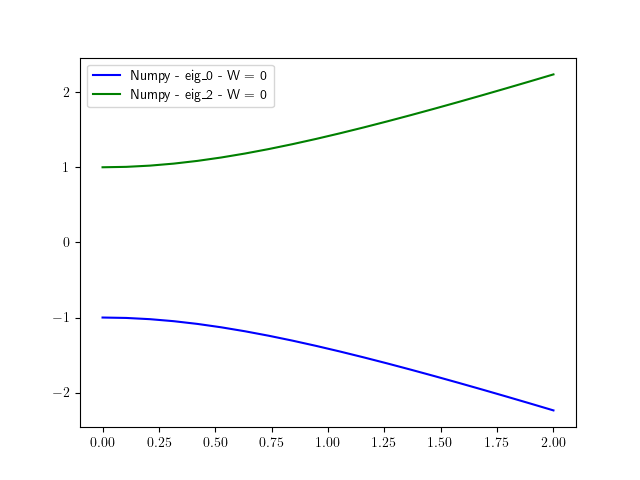

In [36]:
plt.figure()
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_W0[0,:], linestyle="-", color="blue", label="Numpy - eig_0 - W = 0")
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_W0[2,:], linestyle="-", color="green", label="Numpy - eig_2 - W = 0")
plt.legend()

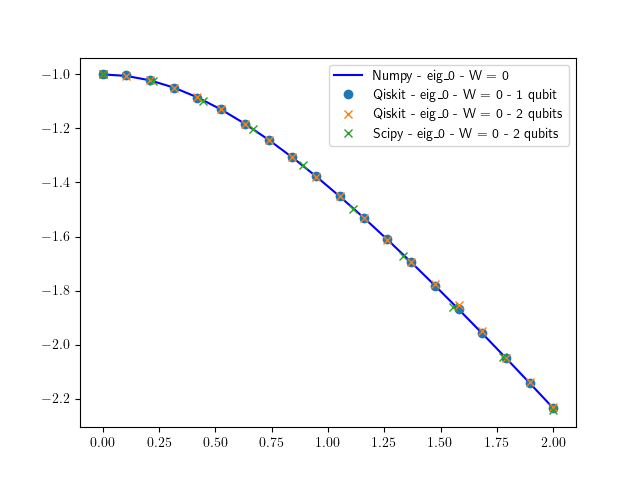

In [37]:
plt.figure()
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_W0[0,:], linestyle="-", color="blue", label="Numpy - eig_0 - W = 0")

plt.plot(np.linspace(0,2,n), minimum_eigenvalues_1p_W0, marker="o", linestyle="", label="Qiskit - eig_0 - W = 0 - 1 qubit")
plt.plot(np.linspace(0,2,n), minimum_eigenvalues_2p_W0, marker="x", linestyle="", label="Qiskit - eig_0 - W = 0 - 2 qubits")
plt.plot(v_vals, min_energy_scipy, marker="x", linestyle="", label="Scipy - eig_0 - W = 0 - 2 qubits")

plt.legend()


We can consider the case $W=-1.5$

In [38]:
# Let's consider the case for W = -1.5
n = 20
Eigenvalue_2p_Wminus1_5 = np.zeros((3,n))
Eigvector_2p_Wminus1_5 = [np.zeros((3,3)).copy() for _ in range(n)]
def eigen(A):
    eigenValues, eigenVectors = np.linalg.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

for i, V in enumerate(np.linspace(0,2,n)):
    H_2p = Hamiltonian_Lipkin(N=2, epsilon=1, V=V, W=-1.5, print_H=False)
    eigenValues, eigenVectors = eigen(H_2p)
    Eigenvalue_2p_Wminus1_5[0,i] = eigenValues[0]
    Eigenvalue_2p_Wminus1_5[1,i] = eigenValues[1]
    Eigenvalue_2p_Wminus1_5[2,i] = eigenValues[2]
    Eigvector_2p_Wminus1_5[i][:,0] = eigenVectors[0]
    Eigvector_2p_Wminus1_5[i][:,1] = eigenVectors[1]
    Eigvector_2p_Wminus1_5[i][:,2] = eigenVectors[2]

In [39]:
W = -1.5
n = 20
# we will iterate over these different optimizers
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=400)
epsilon=1
minimum_eigenvalues_2p_Wminus1_5= []
for i, V in enumerate(tqdm(np.linspace(0,2,n))):
    hamiltonian_2p_Wminus1_5 = SparsePauliOp.from_list(
        [("ZI", epsilon/2), ("IZ", epsilon/2), ("XX", (-V+W)/2), ("YY", (W+V)/2)]
    )
    ansatz = TwoLocal(num_qubits=2, rotation_blocks=["rx","ry"], entanglement_blocks="cz", reps=2)
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_2p_Wminus1_5)
    minimum_eigenvalues_2p_Wminus1_5 +=[result.eigenvalue.real]

/tmp/ipykernel_7302/3839246927.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


In [40]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 20)
min_energy_scipy = np.zeros(len(v_vals))
w=-1.5
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, w, number_shots), method = 'Powell', options = {'maxiter': 3000}, tol = 1e-15)

    min_energy_scipy[index] = res.fun

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


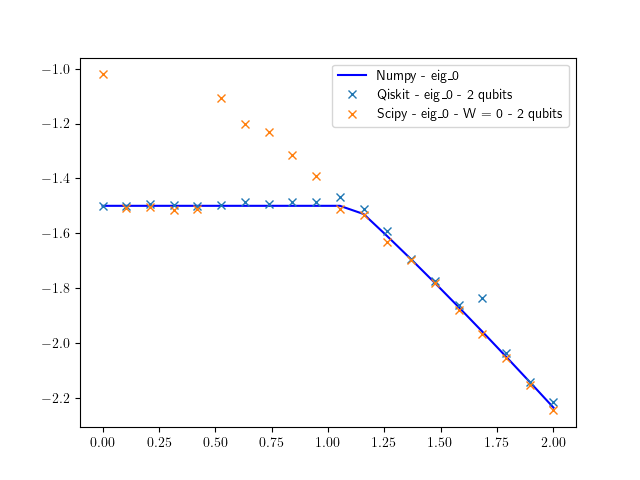

In [41]:
plt.figure()
plt.plot(np.linspace(0,2,n), Eigenvalue_2p_Wminus1_5[0,:], linestyle="-", color="blue", label="Numpy - eig_0 ")

plt.plot(np.linspace(0,2,n), minimum_eigenvalues_2p_Wminus1_5, marker="x", linestyle="", label="Qiskit - eig_0 - 2 qubits")
plt.plot(v_vals, min_energy_scipy, marker="x", linestyle="", label="Scipy - eig_0 - W = 0 - 2 qubits")

plt.legend()

## Lipkin with 4 particles, J=2

In [42]:
H_Lipkin_4p = Hamiltonian_Lipkin(N=4, print_H=True)

⎡-2⋅ε     0     √6⋅V     0      0  ⎤
⎢                                  ⎥
⎢ 0    3⋅W - ε   0      3⋅V     0  ⎥
⎢                                  ⎥
⎢√6⋅V     0     4⋅W      0     √6⋅V⎥
⎢                                  ⎥
⎢ 0      3⋅V     0    3⋅W + ε   0  ⎥
⎢                                  ⎥
⎣ 0       0     √6⋅V     0     2⋅ε ⎦


In [43]:
H_Lipkin_4p

array([[-2.        ,  0.        ,  2.44948974,  0.        ,  0.        ],
       [ 0.        ,  2.        ,  0.        ,  3.        ,  0.        ],
       [ 2.44948974,  0.        ,  4.        ,  0.        ,  2.44948974],
       [ 0.        ,  3.        ,  0.        ,  4.        ,  0.        ],
       [ 0.        ,  0.        ,  2.44948974,  0.        ,  2.        ]])

We can compute the eigenvalues using Numpy's library linalg 

In [44]:
# Let's consider the case for W = 0
n = 20
Eigenvalue_4p_W0 = np.zeros((5,n))
Eigvector_4p_W0 = [np.zeros((5,5)).copy() for _ in range(n)]

for i, V in enumerate(np.linspace(0,2,n)):
    H_2p = Hamiltonian_Lipkin(N=4, epsilon=1, W=0, V=V, print_H=False)
    eigenValues, eigenVectors = eigen(H_2p)
    Eigenvalue_4p_W0[0,i] = eigenValues[0]
    Eigenvalue_4p_W0[1,i] = eigenValues[1]
    Eigenvalue_4p_W0[2,i] = eigenValues[2]
    Eigenvalue_4p_W0[3,i] = eigenValues[3]
    Eigenvalue_4p_W0[4,i] = eigenValues[4]
    Eigvector_4p_W0[i][:,0] = eigenVectors[0]
    Eigvector_4p_W0[i][:,1] = eigenVectors[1]
    Eigvector_4p_W0[i][:,2] = eigenVectors[2]
    Eigvector_4p_W0[i][:,3] = eigenVectors[3]
    Eigvector_4p_W0[i][:,4] = eigenVectors[4]

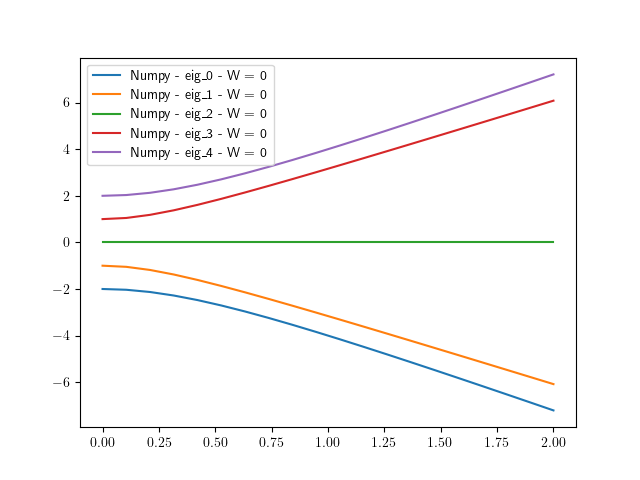

In [45]:
plt.figure()
plt.plot(np.linspace(0,2,n), Eigenvalue_4p_W0[0,:], linestyle="-", label="Numpy - eig_0 - W = 0")
plt.plot(np.linspace(0,2,n), Eigenvalue_4p_W0[1,:], linestyle="-", label="Numpy - eig_1 - W = 0")
plt.plot(np.linspace(0,2,n), Eigenvalue_4p_W0[2,:], linestyle="-", label="Numpy - eig_2 - W = 0")
plt.plot(np.linspace(0,2,n), Eigenvalue_4p_W0[3,:], linestyle="-", label="Numpy - eig_3 - W = 0")
plt.plot(np.linspace(0,2,n), Eigenvalue_4p_W0[4,:], linestyle="-", label="Numpy - eig_4 - W = 0")
plt.legend()

We can rewrite the Hamiltonian as a function of Pauli's matrices and utilize Qiskit to compute the smallest eigenvalue.

In [46]:
W = 0
n = 10
# we will iterate over these different optimizers
estimator = Estimator(options={"shots": 1024})
optimizer = SPSA(maxiter=1000)
epsilon=1
minimum_eigenvalues_4p_W0 = []
for i, V in enumerate(tqdm(np.linspace(0,2,n))):
    hamiltonian_4p_W0 = SparsePauliOp.from_list([("ZIII", epsilon/2),
                                          ("IZII", epsilon/2),
                                          ("IIZI", epsilon/2),
                                          ("IIIZ", epsilon/2),
                                          ("XXII", (W+V)/2),
                                          ("XIXI", (W+V)/2),
                                          ("XIIX", (W+V)/2),
                                          ("IXXI", (W+V)/2),
                                          ("IXIX", (W+V)/2),
                                          ("IIXX", (W+V)/2),
                                          ("YYII", (W-V)/2),
                                          ("YIYI", (W-V)/2),
                                          ("YIIY", (W-V)/2),
                                          ("IYYI", (W-V)/2),
                                          ("IYIY", (W-V)/2),
                                          ("IIYY", (W-V)/2)]
                                         )
    ansatz = TwoLocal(num_qubits=4, rotation_blocks=["rx","ry"], entanglement_blocks="cx", reps=2)
    vqe = VQE(estimator, ansatz, optimizer)
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian_4p_W0)
    minimum_eigenvalues_4p_W0 +=[result.eigenvalue.real]

/tmp/ipykernel_7302/289833334.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(options={"shots": 1024})
 50%|█████     | 5/10 [01:05<01:05, 13.11s/it]


KeyboardInterrupt: 

In [ ]:
plt.figure()
plt.plot(np.linspace(0,2,20), Eigenvalue_4p_W0[0,:], linestyle="-", label="Numpy - eig_0 - W = 0")
plt.plot(np.linspace(0,2,20), Eigenvalue_4p_W0[1,:], linestyle="-", label="Numpy - eig_1 - W = 0")
plt.plot(np.linspace(0,2,20), Eigenvalue_4p_W0[2,:], linestyle="-", label="Numpy - eig_2 - W = 0")
plt.plot(np.linspace(0,2,20), Eigenvalue_4p_W0[3,:], linestyle="-", label="Numpy - eig_3 - W = 0")
plt.plot(np.linspace(0,2,20), Eigenvalue_4p_W0[4,:], linestyle="-", label="Numpy - eig_4 - W = 0")
plt.plot(np.linspace(0,2,10), minimum_eigenvalues_4p_W0, marker="o")
plt.legend()

We can rearrange the Hamiltonian such that it has a block diagonal structure


In [ ]:
def Hamiltonian_Lipkin_blockdiagonal(N=2, epsilon=1.0, V=1.0, W=1.0, print_H=False):
    # Define symbolic parameters for pretty printing
    eps_sym, V_sym, W_sym = sp.symbols('epsilon V W')
    
    # Define the Hamiltonian symbolically (write it only once)
    if N == 2:
        # Get lower right block
        H_sym = sp.Matrix([
            [-eps_sym+3*W_sym,   3*V_sym],
            [3*V_sym, eps_sym+3*W_sym]
        ])
    elif N == 4:
        # Get higher left block
        H_sym = sp.Matrix([
            [-2*eps_sym,        sp.sqrt(6)*V_sym,  0,          0],
            [sp.sqrt(6)*V_sym, 4*W_sym,         0,     sp.sqrt(6)*V_sym],
            [ 0,         0,         0,         0],
            [ 0,      sp.sqrt(6)*V_sym,         0, 2*eps_sym]
        ])
    else:
        print("N must be 2 or 4")
        return None

    # Pretty print the symbolic Hamiltonian if requested
    if print_H:
        sp.pprint(H_sym)
    
    # Substitute the numeric values into the symbolic Hamiltonian and convert to a NumPy array
    H_numeric = np.array(H_sym.subs({eps_sym: epsilon, V_sym: V, W_sym: W}), dtype=float)
    return H_numeric

In [ ]:
H_upper_block = Hamiltonian_Lipkin_blockdiagonal(N=4, print_H=True)

We can compute its eigenvalues using Numpy

In [ ]:
n = 20
# Create a list with 4 sublists, each containing n elements (initially zeros)
Eigenvalue_upperblock_W0 = np.zeros((4,n))
Eigvector_upperblock_W0 = [np.zeros((4,4)) for _ in range(n)]

for i, V in enumerate(np.linspace(0, 2, n)):
    H_upperblock = Hamiltonian_Lipkin_blockdiagonal(N=4, epsilon=1, V=V, W=0, print_H=False)
    eigenValues, eigenVectors = eigen(H_upperblock)
    Eigenvalue_upperblock_W0[0,i] = eigenValues[0]
    Eigenvalue_upperblock_W0[1,i] = eigenValues[1]
    Eigenvalue_upperblock_W0[2,i] = eigenValues[2]
    Eigenvalue_upperblock_W0[3,i] = eigenValues[3]
    Eigvector_upperblock_W0[i][:, 0] = eigenVectors[0]
    Eigvector_upperblock_W0[i][:, 1] = eigenVectors[1]
    Eigvector_upperblock_W0[i][:, 2] = eigenVectors[2]
    Eigvector_upperblock_W0[i][:, 3] = eigenVectors[3]

To compute the energy using quantum principles we need to rewrite the Hamiltonian as function of Pauli matrices
$$
\begin{aligned}
H^{''} &= W\, (I_1I_2) - W\, (Z_1Z_2)+ (W-\epsilon)\, (Z_1) - (\epsilon+W)\, (Z_2)\\[1mm]
&\quad + \frac{\sqrt{6}}{2}\,V \left[X_2+X_1+Z_1X_2-X_1Z_2\right].
\end{aligned}
$$


In [ ]:
def prepare_state(theta0, phi0, theta1, phi1, target = None):
    qubit = Two_qubit()
    qubit.set_state([1, 0, 0, 0])
    qubit.rotate_x(theta0, 0)
    qubit.rotate_y(phi0, 0)
    qubit.rotate_x(theta1, 1)
    qubit.rotate_y(phi1, 1)
    qubit.apply_cnot01() # entangle the two qubits
    if target is not None:
        qubit.state = target
    return qubit.state

def get_energy(angles, v, w, number_shots, target = None):
    theta0, phi0, theta1, phi1 = angles
    
    init_state = prepare_state(theta0, phi0, theta1, phi1, target)
    qubit = Two_qubit()

    ZI = np.kron(qubit.Z, qubit.I)

    qubit.set_state(init_state)
    qubit.apply_cnot10() # rotate measurement basis
    measure_zz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_swap() # rotate measurement basis
    measure_iz = qubit.measure(number_shots)

    qubit.set_state(init_state)
    measure_zi = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    qubit.apply_swap()
    measure_ix = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_hadamard(0)
    measure_xi = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_cnot10()
    qubit.apply_hadamard(1)
    measure_zx = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_cnot10()
    qubit.apply_hadamard(1)
    qubit.apply_swap()
    measure_xz = qubit.measure(number_shots)


    # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
    exp_vals = np.zeros(7) # do not include the expectation value of II
    measures = np.array([measure_zz, measure_zi, measure_iz, measure_ix, measure_xi, measure_zx, measure_xz])
    constants = np.array([-w, (w-1), -(1+w), np.sqrt(6)/2*v,np.sqrt(6)/2*v,np.sqrt(6)/2*v,np.sqrt(6)/2*v])
    for index in range(len(exp_vals)):
        counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
        exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

    exp_val = w + np.sum(constants * exp_vals) / number_shots
    return exp_val


In [ ]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy_upper_block = np.zeros(len(v_vals))
w=0
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (v, w, number_shots), method = 'Powell', options = {'maxiter': 4000}, tol = 1e-10)
    min_energy_scipy_upper_block[index] = res.fun
    # print(res.message)

Let's consider the lower right block
$$
\begin{aligned}
H^{'} &= 3WI - \epsilon Z + 3V I.
\end{aligned}
$$

In [ ]:
def prepare_state(theta, phi, target = None):
    I = np.eye(2)
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_y = np.array([[0, -1j], [1j, 0]])
    state = np.array([1, 0])
    Rx = np.cos(theta/2) * I - 1j * np.sin(theta/2) * sigma_x
    Ry = np.cos(phi/2) * I - 1j * np.sin(phi/2) * sigma_y
    state = Ry @ Rx @ state
    if target is not None:
        state = target
    return state

def get_energy(angles, v, w, number_shots, target = None):
    theta, phi = angles[0], angles[1]

    init_state = prepare_state(theta, phi, target)
    qubit = One_qubit()
    qubit.set_state(init_state)
    measure_z = qubit.measure(number_shots)

    qubit.set_state(init_state)
    qubit.apply_hadamard()
    measure_x = qubit.measure(number_shots)
    
    # expected value of Z = (number of 0 measurements - number of 1 measurements)/ number of shots
    # number of 1 measurements = sum(measure_z)
    exp_val_z = 1*(number_shots - 2*np.sum(measure_z)) / number_shots
    exp_val_x = 3*v*(number_shots - 2*np.sum(measure_x)) / number_shots
    exp_val_i = 3*w 
    exp_val = (exp_val_z + exp_val_x + exp_val_i)
    return exp_val 

In [ ]:
number_shots = 10_000
v_vals = np.linspace(0.0, 2.0, 10)
min_energy_scipy_lower_block = np.zeros(len(v_vals))
w=0
for index, v in enumerate(tqdm(v_vals)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 2)
    res = minimize(get_energy, angles_start, args = (v, w, number_shots), method = 'Powell', options = {'maxiter': 4000}, tol = 1e-10)
    min_energy_scipy_lower_block[index] = res.fun
    # print(res.message)

In [ ]:
plt.figure()
plt.plot(np.linspace(0, 2, 20),  Eigenvalue_upperblock_W0[0,:])
plt.plot(np.linspace(0.0, 2.0, 10), min_energy_scipy_upper_block, marker="o")
# plt.plot(np.linspace(0.0, 2.0, 10), min_energy_scipy_lower_block, marker="o")
# plt.plot(np.linspace(0,2,10), minimum_eigenvalues_4p_W0)